In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import chrombpnet.training.utils.losses as losses
import chrombpnet.training.utils.one_hot as one_hot
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ---- Step 1: Load model ----

def load_model_wrapper(model_h5):
    # read .h5 model
    custom_objects={"multinomial_nll":losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_h5, compile=False)
    #model.summary()
    return model

MODEL_PATH = "results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"  # Change this path to your actual model
model = load_model_wrapper(MODEL_PATH)

2025-07-10 16:36:07.046055: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 16:36:08.003072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10077 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
# ---- Step 2: Input your custom 2114bp sequence ----

# Make sure it only contains A, C, G, T
def load_sequences_from_fasta(fasta_path):
    sequences = []
    with open(fasta_path) as f:
        current_seq = []
        for line in f:
            if line.startswith(">"):
                if current_seq:
                    sequences.append("".join(current_seq))
                    current_seq = []
            else:
                current_seq.append(line.strip())
                
        if current_seq:
            assert len("".join(current_seq)) == 2114, "Input sequence must be exactly 2114 bp long."
            sequences.append("".join(current_seq))
    return sequences
    
sequences = load_sequences_from_fasta("example.fa") 

# ---- Step 3: One-hot encode the sequence ----

one_hot_seqs = one_hot.dna_to_one_hot(sequences)  # shape: (N, 2114, 4)
print("One-hot shape:", one_hot_seqs.shape)

# ---- Step 4: Get prediction ----

pred_logits_wo_bias, pred_logcts_wo_bias = model.predict(one_hot_seqs)

def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)
    
predictions = softmax(pred_logits_wo_bias) * (np.expand_dims(np.exp(pred_logcts_wo_bias)[:,0],axis=1)) # final predcitions you can use

print("Prediction logits shape:", pred_logits_wo_bias.shape) # (N, 1000)
print("Prediction logcnt shape:", pred_logcts_wo_bias.shape) # (N, 1)
print("Prediction shape:", predictions.shape) # (N, 1000)


One-hot shape: (2, 2114, 4)


2025-07-10 16:36:09.727408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Prediction logits shape: (2, 1000)
Prediction logcnt shape: (2, 1)
Prediction shape: (2, 1000)


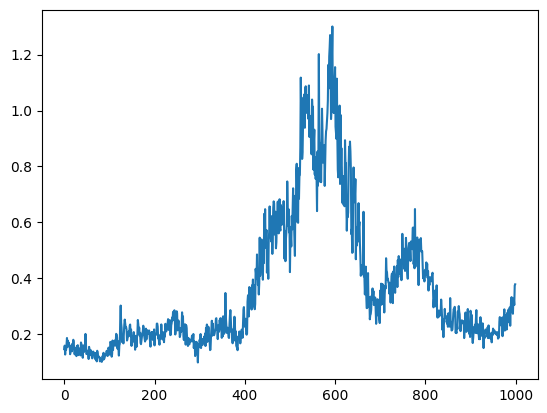

In [4]:
index=0 # plot predictions for example 0
plt.plot(predictions[index])